In [ ]:
# --- Hyperparameter grid ---
parameters = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# --- Initialize storage ---
metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
models = []
f1_scores = []
roc_curves = []
conf_matrices = []
fold = 1

# SHAP-related
shap_values_all = []
shap_test_sets = []

# Define cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Cross-validation loop ---
for train_index, test_index in cv.split(X, y):
    print(f'\n--- Working on fold {fold} ---')

    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE to training data
    smote = SMOTE(random_state=fold)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # Grid search on scaled, resampled training data
    knn = KNeighborsClassifier()
    clf_GS = GridSearchCV(knn, parameters, cv=5, scoring='f1')
    clf_GS.fit(X_train_scaled, y_train_resampled)

    # Evaluate best model
    best_model = clf_GS.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    # SHAP: use sampled background for speed
    background = shap.sample(X_train_scaled, 100, random_state=fold)
    explainer = shap.KernelExplainer(best_model.predict_proba, background)
    shap_values = explainer.shap_values(X_test_scaled)
    shap_values_all.append(shap_values)
    shap_test_sets.append(pd.DataFrame(X_test_scaled, columns=X.columns))

    # ROC and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    metrics['roc_auc'].append(roc_auc)
    roc_curves.append((fpr, tpr, roc_auc, fold))
    plt.plot(fpr, tpr, label=f'Fold {fold} (AUC = {roc_auc:.2f})')

    # Classification metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Fold {fold} — F1 score: {f1:.4f}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print('  Best n_neighbors:', best_model.get_params()['n_neighbors'])
    print('  Best weights:', best_model.get_params()['weights'])
    print('  Best metric:', best_model.get_params()['metric'])

    # Store results
    metrics['accuracy'].append(acc)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1'].append(f1)
    f1_scores.append(f1)
    models.append(best_model)

    # Store confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)

    fold += 1

# --- Identify best model ---
best_index = f1_scores.index(max(f1_scores))
best_model_overall = models[best_index]

# Reconstruct best model for export/deployment
params = best_model_overall.get_params()
b_model = KNeighborsClassifier(
    n_neighbors=params["n_neighbors"],
    weights=params["weights"],
    metric=params["metric"]
)

# --- Final ROC plot ---
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — KNN (5-fold CV)', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# --- Confusion Matrix Plot ---
plt.close('all')
plt.figure(figsize=(6, 5))
mean_cm = np.mean(conf_matrices, axis=0)
mean_cm_percent = 100 * mean_cm / mean_cm.sum(axis=1, keepdims=True)

class_labels = ['Non-Diabetes', 'Diabetes']
sns.heatmap(mean_cm_percent, annot=True, fmt='.2f', cmap='Blues_r',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': '% of True Class'})
plt.title('Mean Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
do it witth all the values insetad of backgroudn

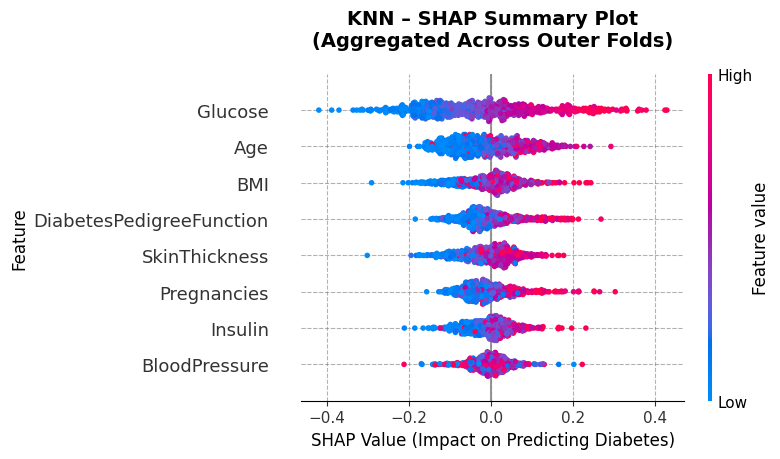

In [50]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl

# STEP 1: Force a visible white theme with clear gridlines
plt.style.use('default')  # Reset to default style
mpl.rcParams.update({
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'text.color': 'black',
    'figure.facecolor': 'white',
    'savefig.facecolor': 'white',
    'grid.color': 'gray',
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.6
})

# STEP 2: Combine SHAP values and test data for class 1
all_shap_values = np.vstack([sv[:, :, 1] for sv in shap_values_all])
all_X_test = pd.concat(shap_test_sets, axis=0)
all_X_test.columns = X.columns
feature_names = X.columns

# STEP 3: Create SHAP summary plot (uses matplotlib internally)
shap.summary_plot(
    all_shap_values,
    all_X_test,
    feature_names=feature_names,
    show=False
)

# STEP 4: Customize plot styling
fig = plt.gcf()
ax = plt.gca()

# Add clear title and axis labels
plt.title('KNN – SHAP Summary Plot\n(Aggregated Across Outer Folds)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('SHAP Value (Impact on Predicting Diabetes)', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Ensure layout and export
plt.tight_layout()
plt.savefig('../../output/KNN_output/knn_shap_final.png', dpi=300)
plt.show()
plt.close()
